# Ungraded Lab: Training a Sarcasm Detection Model using Bidirectional LSTMs

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) dataset and use it to train a Bi-LSTM Model.


## Imports

In [4]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

## Load the Dataset

First, you will download the JSON file and extract the contents into lists.

In [5]:
# The dataset is already downloaded for you. For downloading you can use the code below.
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

In [6]:
# Load the JSON file
with open('/kaggle/input/sarcasm/sarcasm.json', 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Parameters

We placed the constant parameters in the cell below so you can easily tweak it later:

In [7]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Type of padding
PADDING_TYPE = 'pre'

# Specifies how to truncate the sequences
TRUNC_TYPE = 'post'

## Split the Dataset

You will then split the lists into train and test sets.

In [8]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

## Data preprocessing

Next, you will generate the vocabulary and padded sequences.

In [9]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

You will combine the sentences and labels, then put them in a `tf.data.Dataset`. This will let you leverage the `tf.data` pipeline methods you've been using to preprocess the dataset.

In [10]:
# Put the sentences and labels in a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

You will use the same preprocessing function from the previous lab to generate the padded sequences.

In [11]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Apply the vectorization layer to the string features
  dataset_sequences = dataset.map(
      lambda text, label: (vectorize_layer(text), label)
      )

  # Put all elements in a single ragged batch
  dataset_sequences = dataset_sequences.ragged_batch(
      batch_size=dataset_sequences.cardinality()
      )

  # Output a tensor from the single batch. Extract the sequences and labels.
  sequences, labels = dataset_sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(
      sequences.numpy(),
      maxlen=MAX_LENGTH,
      truncating=TRUNC_TYPE,
      padding=PADDING_TYPE
      )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  # Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [12]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

It's always good to check a few examples to see if the transformation works as expected.

In [13]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,  315, 3112, 5469, 2213,    3,  651, 1033],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 6627, 1698,  705,
       2511,   44,  236,   11, 1852, 1024,    8, 1938, 1906, 2202],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



Then, you will optimize and batch the dataset.

In [14]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Plot Utility

In [15]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Build and Compile the Model

The architecture here is almost identical to the one you used in the previous lab with the IMDB Reviews. Try to tweak the parameters and see how it affects the training time and accuracy (both training and validation).

In [16]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,129 (680.19 KB)

 Trainable params: 174,129 (680.19 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [17]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6749 - loss: 0.5569 - val_accuracy: 0.8489 - val_loss: 0.3366
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8905 - loss: 0.2653 - val_accuracy: 0.8470 - val_loss: 0.3717
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9246 - loss: 0.1935 - val_accuracy: 0.8473 - val_loss: 0.4008
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9505 - loss: 0.1367 - val_accuracy: 0.8387 - val_loss: 0.4362
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9686 - loss: 0.0928 - val_accuracy: 0.8377 - val_loss: 0.5476
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9816 - loss: 0.0601 - val_accuracy: 0.8364 - val_loss: 0.6727
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9882 - loss: 0.0365 - val_accuracy: 0.8288 - val_loss: 0.8187
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9924 - loss: 0.0236 - 

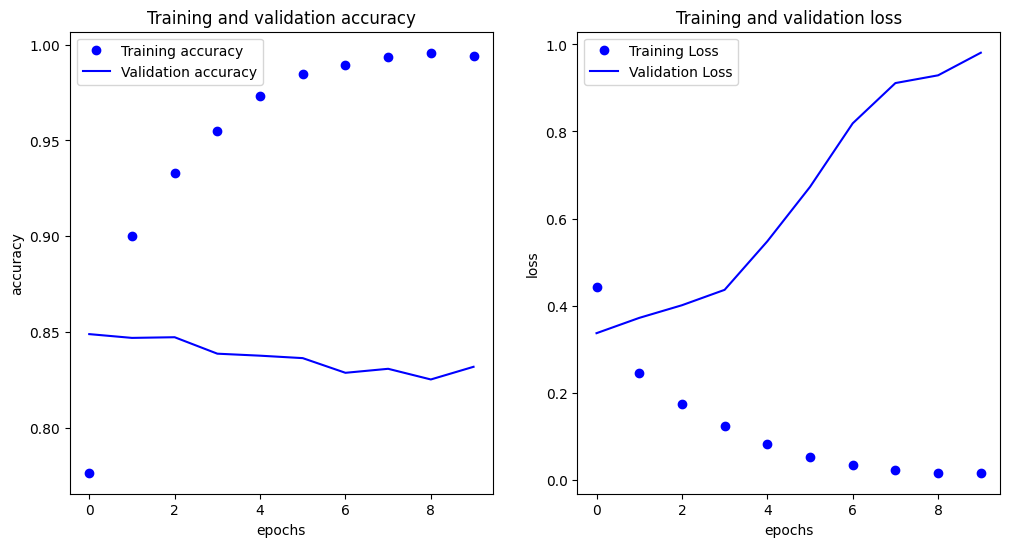

In [18]:
# Plot the accuracy and loss
plot_loss_acc(history_lstm)

## Wrap Up

This concludes this lab on using LSTMs for the Sarcasm dataset. You will explore another architecture in the next lab. Before doing so, run the cell below to free up resources.

In [19]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}